Criando uma rede neural pra gerar imagens e outra para discriminar se a imagem gerada é a artificial ou se é uma imagem real.

In [21]:
import tensorflow as tf

In [22]:
import glob         # glob e imageio pra gerar gif com as minhas épocas da rede treinada ao final
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL          #pra manipular imagens
from tensorflow.keras import layers
import time

from IPython import display

In [23]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [24]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5           #Normalizando as imagens para irem de -1 a 1.

In [25]:
# Definindo algumas constantes padrão do tamanho do meu conjunto (60k imagens)
BUFFER_SIZE = 60000
BATCH_SIZE = 256        # A quantidade de bits que ele varia

In [26]:
# É utilizado o tensor_slices pra fazer uma transformação no meu dataset, usando o shuffle
# pra trazer o tamanho do meu conjunto e o batch pra normalizar esses 256 pixels.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [27]:
 #Construindo camada por camada do meu modelo GERADOR de imagens.
 def make_generator_model():
    model = tf.keras.Sequential()      #vamos usar o modelo do tipo Sequential e ir add as camadas uma a uma
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))       #A função assert é pra comparar e ver se estamos atingindo o esperado
    assert model.output_shape == (None, 7, 7, 256)          #None é o tamanho do Batch

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

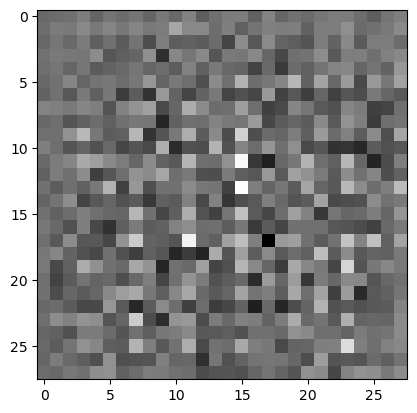

In [28]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

# essa é a visão de uma imagem nunca treinada, gerada a partir de um não-treinamento. 
# É a rede neural do jeito que veio ao mundo.

In [31]:
# Passado isso, vou criar o modelo discriminador. vai ter menos camadas do que o gerador, pois discriminar
# é mais fácil do que gerar.
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [32]:
#Construídas as duas funções, vamos instanciar o modelo discriminador
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print(decision)
#como o valor gerado abaixo foi positivo, significa que o meu discriminador entendeu que a figura crua 
# acima era real.

tf.Tensor([[0.00183487]], shape=(1, 1), dtype=float32)


In [33]:
#Toda rede neural trabalha com uma função de custo. Usaremos uma famosa função chamada CrossEntropy.
#Em seguida serão criadas funções de custo tanto pro gerador quanto pro discriminador.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss   

In [35]:
#Só destacar que pro gerador, só me importa o fakeoutput. Só o discriminador que vai precisar
#  ter o real e o fake pra comparar
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [36]:
#Normalmente utilizamos o otimizador Adam. Aplicaremos tanto pro gerador quanto pro discriminador
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [37]:
# É muito importante, quando construindo uma rede neural, criarmos um checkpoint.
# Pois, se der algum problema na máquina ou internet etc, não precisaremos recomeçar do zero o treinamento.

checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)   

In [38]:
# Vamos criar um GIF, para que vejamos a evolução das imagens em forma de uma animação.

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [40]:
@tf.function    #aqui eu passo um decorator function só pra ele dizer que esse cara foi compilado em algum momento.
#São boas práticas quando se trabalha com deep learning. Usado pra criar modelos portáteis do TensorFlow.

#Aqui vou criar uma função de etapas de treinamento, que vai receber as imagens e no final vai aplicar os otimizadores
# e criando as tuplas.
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #basicamente estamos resumindo métodos muito
        generated_images = generator(noise, training=True)              #grandes, classes ou até nomes de arquivos 
                                                                        #em pequenos valores de variáveis (gen e disc)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [41]:
#De fato temos agora a função de treino, que vai receber tanto os datasets quanto as épocas
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)                         #Aqui estamos produzindo as imagens pro GIF
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:                               #salvando o modelo a cada 15 épocas
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print("Time for epoch {} is {} sec".format(epoch + 1, time.time()-start))
    
    display.clear_output(wait=True)                             #São geradas as imagens e depois salvas
    generate_and_save_images(generator, epochs, seed)

In [42]:
#essa função é a que vai gerar as imagens, recebendo o modelo, a qtd de épocas e o test_input
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [ ]:
#Aplicando o treinamento, vamos receber de output o tempo que ele demorou e 4x4 imagens.
#No diretório, dá pra ver a evolução das imagens. Mas ainda assim, com 50 épocas, ainda estamos longe de ficar bom.
#Teria que aumentar o número de épocas.

#Do professor levou 2h30.
train(train_dataset, EPOCHS)